# Interpolate From `MeshArray` To Given Position

Each `MeshArray` contains an array of elementary arrays that (1) are connected at their edges and (2) collectively form a global grid. Overall grid specifications are contained within `gcmgrid` instances, which merely define array sizes and how e.g. grid variables are represented in memory. Importantly, it is only when e.g. grid variables are read from file that sizable memory is allocated.

## Initialize Framework

1. import `MeshArrays` and plotting tools
2. choose e.g. a standard `MITgcm` grid
3. download the grid if needed


In [1]:
using MeshArrays, Plots

pth="../inputs/GRID_LLC90/"
γ=GridSpec("LatLonCap",pth)

http="https://github.com/gaelforget/GRID_LLC90"
!isdir(pth) ? run(`git clone $http $pth`) : nothing;

## Interpolation Code

- get map of tile numbers
- find nearest neighbor
- stereographic projection (tile)
- array of quadrilaterals (tile)

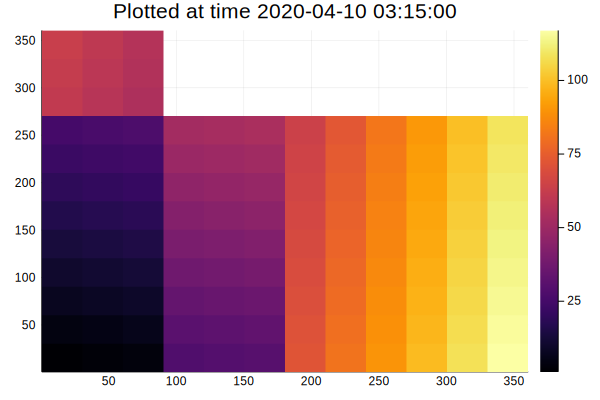

In [2]:
#get map of tile numbers

using MITgcmTools
ni=30; nj=30;
tile=TileMap(γ,ni,nj)
qwckplot(tile)

In [3]:
# find nearest neighbor

using NearestNeighbors

#XC=collect(0.1:0.5:2.1); YC=collect(0.1:0.5:2.1);
XC=0.1; YC=0.1;

Γ=GridLoad(γ)
XC_a=write(Γ["XC"])
YC_a=write(Γ["YC"])
tile_a=write(tile)
kk=findall(isfinite.(XC_a))

x=sin.(pi/2 .-YC_a[kk]*pi/180).*cos.(XC_a[kk]*pi/180);
y=sin.(pi/2 .-YC_a[kk]*pi/180).*sin.(XC_a[kk]*pi/180);
z=cos.(pi/2 .-YC_a[kk]*pi/180);

xx=sin.(pi/2 .-YC*pi/180).*cos.(XC*pi/180);
yy=sin.(pi/2 .-YC*pi/180).*sin.(XC*pi/180);
zz=cos.(pi/2 .-YC*pi/180);

kdtree = KDTree([x y z]')
idxs, dists = knn(kdtree, [xx yy zz]', 4, true)

ik=[idxs[i][1] for i in 1:length(XC)]
[XC_a[ik] YC_a[ik]]

1×2 Array{Float64,2}:
 0.5  0.199365

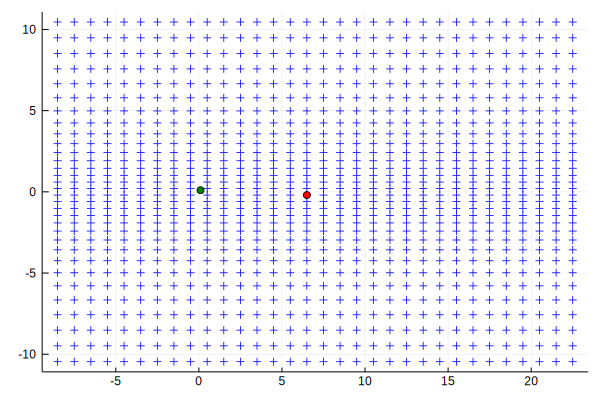

In [4]:
XC_e=exchange(Γ["XC"])
YC_e=exchange(Γ["YC"])

list_tile=[tile_a[ik]]; 
ii=1; iiTile=Int(list_tile[ii][1])
tmp1=1*(tile.==iiTile)
iiFace=findall(maximum.(tmp1.f).>0)[1]

tmp1=tmp1.f[iiFace]
tmp11=findall(sum(tmp1,dims=2).>0)
iiMin=minimum(tmp11)[1]
iiMax=maximum(tmp11)[1]
tmp11=findall(sum(tmp1,dims=1).>0)
jjMin=minimum(tmp11)[2]
jjMax=maximum(tmp11)[2]

#iiPoints=findall(tmp1.>0)
XC_tmp=view(XC_e.f[iiFace],iiMin:iiMax+2,jjMin:jjMax+2)
YC_tmp=view(YC_e.f[iiFace],iiMin:iiMax+2,jjMin:jjMax+2)
XC0=Γ["XG"].f[iiFace][iiMin+Int(ni/2),jjMin+Int(nj/2)]
YC0=Γ["YG"].f[iiFace][iiMin+Int(ni/2),jjMin+Int(nj/2)]

#to match gcmfaces test case : interp=gcmfaces_interp_coeffs(0.1,0.1);
XC0=6.5000
YC0=-0.1994

scatter(XC_tmp,YC_tmp,marker=:+,c=:blue,leg=false)
scatter!([XC0],[YC0],c=:red)
scatter!([XC],[YC],c=:green)

In [5]:
function StereographicProjection(XC0,YC0,XC,YC)
#[xx,yy]=gcmfaces_stereoproj(XC0,YC0,XC,YC);
#object:    compute stereographic projection putting XC0,YC0 at 0,0
#inputs:    XC0,YC0 are the origin longitude,latitude
#           XC,YC are the lon,lat points to project
#outputs:   xx,yy are the projected points
#
#for additional information see :
# http://www4.ncsu.edu/~franzen/public_html/CH795Z/math/lab_frame/lab_frame.html
# http://physics.unm.edu/Courses/Finley/p503/handouts/SphereProjectionFINALwFig.pdf

#compute spherical coordinates:
phi=XC; theta=90 .-YC;
phi0=XC0; theta0=90-YC0;

#compute cartesian coordinates:
X=sind.(theta).*cosd.(phi);
Y=sind.(theta).*sind.(phi);
Z=cosd.(theta);

x=X; y=Y; z=Z;

#bring chosen point to the north pole:
xx=x; yy=y; zz=z;
x=cosd(phi0).*xx+sind(phi0).*yy;
y=-sind(phi0).*xx+cosd(phi0).*yy;
z=zz;

xx=x; yy=y; zz=z;
x=cosd(theta0)*xx-sind(theta0)*zz;
y=yy;
z=sind(theta0)*xx+cosd(theta0)*zz;

#stereographic projection from the south pole:
xx=x./(1 .+z);
yy=y./(1 .+z);

#nrm=sqrt(xx.^2+yy.^2); 
#msk=1+0*nrm; msk(nrm>tan(pi/4/2))=NaN;%mask points outside of pi/4 cone

return xx,yy
end

StereographicProjection (generic function with 1 method)

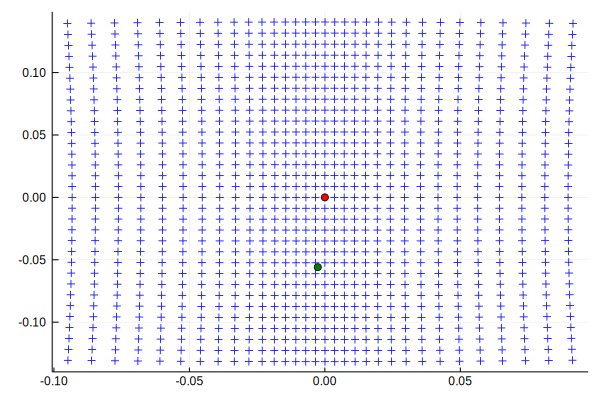

In [6]:
(xx,yy)=StereographicProjection(XC0,YC0,XC_tmp,YC_tmp)
(prof_x,prof_y)=StereographicProjection(XC0,YC0,XC,YC)

#scatter(xx,yy,c=:blue,leg=false)
scatter(xx,yy,marker=:+,c=:blue,leg=false)
scatter!([0.],[0.],c=:red)
scatter!([prof_x],[prof_y],c=:green)

In [7]:
x_quad=Array{Float64,2}(undef,(ni+1)*(nj+1),4)
y_quad=Array{Float64,2}(undef,(ni+1)*(nj+1),4)
i_quad=Array{Int64,2}(undef,(ni+1)*(nj+1),4)
j_quad=Array{Int64,2}(undef,(ni+1)*(nj+1),4)

didj=[[0 0];[1 0];[1 1];[0 1]]
for pp=1:4
    di=didj[pp,1]
    dj=didj[pp,2]

    #note the shift in indices due to exchange above    
    tmp=xx[1+di:ni+1+di,1+dj:nj+1+dj]
    x_quad[:,pp]=vec(tmp)
    tmp=yy[1+di:ni+1+di,1+dj:nj+1+dj]
    y_quad[:,pp]=vec(tmp)

    tmp=collect(0+di:ni+di)*ones(1,nj+1)
    i_quad[:,pp]=vec(tmp)
    tmp=ones(ni+1,1)*transpose(collect(0+dj:nj+dj));    
    j_quad[:,pp]=vec(tmp)    
end

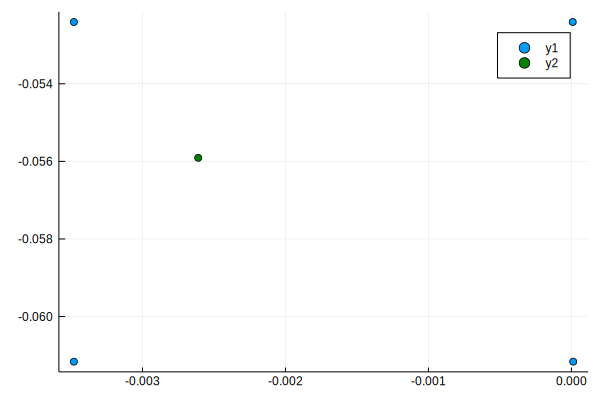

In [8]:
function PolygonAngle(px,py,x=[],y=[])
#object:    compute sum of interior angles for polygons (when input
#           is px,py) or points vs polygons (when input is px,py,x,y)
#inputs:    px,py are MxN matrices where each line specifies one polygon
#(optional) x,y are position vectors
#outputs:   ang are the corresponding sums of interior angles

M=size(px,1); N=size(px,2); P=1;
doPointsInPolygon=false 
if length(x)>0;
    doPointsInPolygon=true
    x=transpose(vec(x))
    y=transpose(vec(y))
    P=length(x)
end;

angsum=zeros(M,P)
for ii=0:N-1    
    ppx=circshift(px,[0 -ii])
    ppy=circshift(py,[0 -ii])        
    if ~doPointsInPolygon
            #compute sum of corner angles
            v1x=ppx[:,2]-ppx[:,1]
            v1y=ppy[:,2]-ppy[:,1]
            v2x=ppx[:,4]-ppx[:,1] 
            v2y=ppy[:,4]-ppy[:,1]
    else;
            #compute sum of sector angles        
            v1x=ppx[:,1]*ones(1,P)-ones(M,1)*x
            v1y=ppy[:,1]*ones(1,P)-ones(M,1)*y
            v2x=ppx[:,2]*ones(1,P)-ones(M,1)*x 
            v2y=ppy[:,2]*ones(1,P)-ones(M,1)*y
    end
    g_acos=acos.( ( v1x.*v2x+v1y.*v2y )./sqrt.( v1x.*v1x+v1y.*v1y )./sqrt.( v2x.*v2x+v2y.*v2y ) )
    g_sin= ( v1x.*v2y-v1y.*v2x )./sqrt.( v1x.*v1x+v1y.*v1y )./sqrt.( v2x.*v2x+v2y.*v2y )
    angsum=angsum+rad2deg.(g_acos.*sign.(g_sin));    
end;

    
    return angsum
end
    
angsum=PolygonAngle(x_quad,y_quad,[prof_x],[prof_y])
ii=findall(angsum.>180.)
II=ii[1].I[1]

scatter(x_quad[II,:],y_quad[II,:])
scatter!([prof_x],[prof_y],c=:green)

In [9]:
[i_quad[II,:]' ; j_quad[II,:]']
[x_quad[II,:]' ; y_quad[II,:]']

2×4 Array{Float64,2}:
  1.2714e-5   9.25405e-6  -0.0034799  -0.0034799
 -0.0611622  -0.0524075   -0.0524081  -0.061163 

### Left to do : 

```
        %5) determine bi-linear interpolation weights:
        px=x_quad(ii_quad,:);
        py=y_quad(ii_quad,:);
        ox=prof_x(ii_prof);
        oy=prof_y(ii_prof);
        [ow]=gcmfaces_quadmap(px,py,ox,oy);
```


In [10]:
function QuadCoeffs(px,py,ox=[],oy=[])
#[ow]=gcmfaces_quadmap(px,py,x,y);
#object:    compute bilinear interpolation coefficients for x(i,:),y(i,:)
#           in px(i,:),py(i,:) by remapping x(i,:),y(i,:) along with the
#           px(i,:),py(i,:) quadrilateral to the 0-1,0-1 square.
#inputs:    px,py are Mx4 matrices where each line specifies one quad
#(optional) ox,oy are MxP position matrices
#outputs:   pw are the MxPx4 bilinear interpolation weights

    #the following test case is based upon https://www.particleincell.com/2012/quad-interpolation/
    #px = [-1, 8, 13, -4];
    #py = [-1, 3, 11, 8];
    #ox=0; oy=6;


#solve linear problem for a,b vectors (knowing px,py)
#  logical (l,m) to physical (x,y) mapping is then
#  x=a(1)+a(2)*l+a(3)*m+a(2)*l*m;
#  y=b(1)+b(2)*l+b(3)*m+b(2)*l*m;
# A=[1 0 0 0;1 1 0 0;1 1 1 1;1 0 1 0]; AI = inv(A);
# AI=[1 0 0 0;-1 1 0 0;-1 0 0 1; 1 -1 1 -1];
# a = AI*px';
# b = AI*py';
tmp1=px[:,1];
tmp2=-px[:,1]+px[:,2];
tmp3=-px[:,1]+px[:,4];
tmp4=px[:,1]-px[:,2]+px[:,3]-px[:,4];
a=[tmp1 tmp2 tmp3 tmp4];

tmp1=py[:,1];
tmp2=-py[:,1]+py[:,2];
tmp3=-py[:,1]+py[:,4];
tmp4=py[:,1]-py[:,2]+py[:,3]-py[:,4];
b=[tmp1 tmp2 tmp3 tmp4];

#chose between the two mapping solutions dep. on sum of interior angles
angsum=PolygonAngle(px,py)
sgn=NaN*px[:,1];
ii=findall(abs.(angsum .-360).<1e-3); sgn[ii].=1.
ii=findall(abs.(angsum .+360).<1e-3); sgn[ii].=-1.
ii=findall(isnan.(angsum))
if length(ii)>0;
    warning("edge point was found");
end;

#solve non-linear problem for pl,pm (knowing px,py,a,b)
#  physical (x,y) to logical (l,m) mapping
#
# quadratic equation coeffs, aa*mm^2+bb*m+cc=0
if ~isempty(ox); 
    x=[px ox]; y=[py oy]; 
else; 
    x=px; y=py; 
end;
a=reshape(a,(size(a,1),1,size(a,2))); a=repeat(a,1,size(x,2),1);
b=reshape(b,(size(b,1),1,size(b,2))); b=repeat(b,1,size(x,2),1);
sgn=repeat(sgn,1,size(x,2));
#
aa = a[:,:,4].*b[:,:,3] - a[:,:,3].*b[:,:,4]
bb = a[:,:,4].*b[:,:,1] -a[:,:,1].*b[:,:,4] + a[:,:,2].*b[:,:,3] - a[:,:,3].*b[:,:,2] + x.*b[:,:,4] - y.*a[:,:,4]
cc = a[:,:,2].*b[:,:,1] -a[:,:,1].*b[:,:,2] + x.*b[:,:,2] - y.*a[:,:,2]

#compute m = (-b+sqrt(b^2-4ac))/(2a)
det = sqrt.(bb.*bb - 4.0*aa.*cc)
pm = (-bb+sgn.*det)./(2.0*aa)
#compute l by substitution in equation system
pl = (x-a[:,:,1]-a[:,:,3].*pm)./(a[:,:,2]+a[:,:,4].*pm)

ow=[];
if ~isempty(ox); 
        tmp1=(1 .-pl[:,5:end]).*(1 .-pm[:,5:end])
        tmp2=pl[:,5:end].*(1 .-pm[:,5:end])
        tmp3=pl[:,5:end].*pm[:,5:end]
        tmp4=(1 .-pl[:,5:end]).*pm[:,5:end]
        ow=cat(tmp1,tmp2,tmp3,tmp4; dims=3)
end

return ow
end

#test case from https://www.particleincell.com/2012/quad-interpolation/
#QuadCoeffs([-1., 8., 13., -4.]',[-1., 3., 11., 8.]',0.,6.)


QuadCoeffs (generic function with 3 methods)

In [11]:
px=x_quad[II,:]'
py=y_quad[II,:]'
ox=prof_x
oy=prof_y

ow=QuadCoeffs(px,py,ox,oy)

Dict("face" => iiFace, "tile" => iiTile, "i" => i_quad[II,:]', "j" => j_quad[II,:]', "w" => vec(ow))

Dict{String,Any} with 5 entries:
  "w"    => [0.0996544, 0.149546, 0.450558, 0.300242]
  "face" => 1
  "j"    => [15 15 16 16]
  "tile" => 17
  "i"    => [8 9 9 8]